In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import CharErrorRate
import matplotlib.pyplot as plt
from skimage import io
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os
import seaborn as sns

D:\Programs\Miniconda\envs\torch_gpu116\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Подготовка данных

In [23]:
class CaptchaDataset(Dataset):
    """Класс содержит собственную реализацию Dataset унаследованную от `torch.utils.data.Dataset`"""

    def __init__(self, paths_to_images, targets_encoded, transforms=None):
        self.paths_to_images = paths_to_images
        self.targets = targets_encoded
        self.transform = transforms

    def __len__(self):
        return len(self.paths_to_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths_to_images[idx]
        image = io.imread(img_name)

        target = self.targets[idx]
        tensorized_target = torch.tensor(target, dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, tensorized_target


def create_loaders(paths_to_images: list,
                   labels: list,
                   transform: transforms,
                   batch_size: int = 16,
                   test_size: float=0.2):
    """
    Функция реализует создание наборов данных

    Parameters
    ------------
    paths_to_images: `list`
        Массив, содержащий пути до изображений
    labels: `np.array`
        Массив, содержащий закодированные метки
    transform: `transforms`
        Преобразования, которые необходимо применить к данным
    batch_size: `int`
        Размер батча
    test_size: `float`
        Размер тестовой части

    Returns
    ------------
    `DataLoader`, `DataLoader`
        Загрузчик данных обучающей части датасета, загрузчик данных тестовой части датасета
    """

    train_img, test_img, train_targets, test_targets = train_test_split(paths_to_images,
                                                                        labels,
                                                                        test_size=test_size,
                                                                        random_state=7)

    train_dataset = CaptchaDataset(train_img, train_targets, transforms=transform)
    test_dataset = CaptchaDataset(test_img, test_targets, transforms=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def extract_data(path_to_file: str):
    """
    Функция для чтения файла аннотации и преобразования данных в формат датасета.
    Для кодирования меток используется `LabelEncoder`

    Parameters
    ------------
    path_to_file: `str`
        Путь до файла с аннотацией

    Returns
    ------------
    `list`, `np.array`, `LabelEncoder`
        Массив путей до изображений, массив закодированных меток, кодировщик меток
    """

    annotations = pd.read_csv(path_to_file)
    paths_to_images = annotations.iloc[:, 0].tolist()
    targets_orig = annotations.iloc[:, 1]

    labels = targets_orig.tolist()
    targets = []
    for ind, x in enumerate(labels):
        t = []
        try:
            for c in x:
                t.append(c)
        except:
            print(f"Skip... {ind=} {x=}")
            continue
        targets.append(t)
        
    # targets = [[c for c in x] for x in labels]
    targets_flat = [c for clist in targets for c in clist]

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(targets_flat)
    targets_enc = [label_encoder.transform(x) for x in targets]
    targets_enc = np.array(targets_enc)

    return paths_to_images, targets_enc, label_encoder


def create_annotations(path_to_dataset: str, path_to_save: str):
    """
    Функция для создания файла аннотации

    Parameters
    ------------
    path_to_dataset: `str`
        Путь к папке с изображениями
    path_to_save: `str`
        Путь, где будет сохранен файл с аннотацией
    """
    paths_to_images = []
    for file_name in os.listdir(path_to_dataset):
        if len(file_name.split('.')) == 2:
            decoding = file_name.split('.')[0]
            paths_to_images.append([os.path.join(path_to_dataset, file_name), decoding])

    pd.DataFrame(data=paths_to_images).to_csv(path_to_save, index=False, header=False)

def fix_annotations(path_to_annotations: str, path_to_dataset: str, path_to_save: str):
    annotations = pd.read_csv(path_to_annotations)
    paths_to_images = annotations.iloc[:, 0].tolist()
    new_paths_to_images = []
    for cur_path in paths_to_images:
        name = os.path.basename(cur_path)
        new_paths_to_images.append(os.path.join(path_to_dataset, name))
    pd.DataFrame({"id": new_paths_to_images, "labels": annotations.iloc[:, 1].tolist()}).to_csv(path_to_save,
                                                                                                header=False,
                                                                                                index=False)
           


def show_landmarks(image):
    """Show image with landmarks"""
    plt.imshow(image, cmap="gray")
    plt.pause(0.001)  # pause a bit so that plots are updated

In [17]:
import torch


def decode_model_output(model_output, encoder):
    """
    Функция декодирования вывода модели

    Parameters
    ------------
    model_output: `tensor`
        Вывод модели
    encoder: `LabelEncoder`
        Кодировщик меток

    Returns
    ------------
    `str`, `list`
        Предсказанная метка, массив предсказанных символов
    """
    model_output_permuted = model_output.permute(1, 0, 2)
    model_output_converted_to_probabilities = torch.softmax(model_output_permuted, 2)
    model_output_BPA_applied_gpu = torch.argmax(model_output_converted_to_probabilities, 2)
    model_output_BPA_applied = model_output_BPA_applied_gpu.detach().cpu().numpy().squeeze()

    model_ouput_label_decoded = []
    for n in model_output_BPA_applied:
        if n == 19:
            model_ouput_label_decoded.append("_")
        else:
            c = encoder.inverse_transform([n])[0]

            model_ouput_label_decoded.append(c)

    model_ouput_without_dublicates = []
    for i in range(len(model_ouput_label_decoded)):
        if i == 0:
            model_ouput_without_dublicates.append(model_ouput_label_decoded[i])
        else:
            if model_ouput_without_dublicates[-1] != model_ouput_label_decoded[i]:
                model_ouput_without_dublicates.append(model_ouput_label_decoded[i])

    model_ouput_without_blanks = []
    for e in model_ouput_without_dublicates:
        if e != "_":
            model_ouput_without_blanks.append(e)
    prediction = "".join(model_ouput_without_blanks)

    return prediction, model_ouput_label_decoded


def decode_batch_outputs(batch_outputs, encoder):
    """
    Функция для декодирования батча

    Parameters
    ------------
    batch_outputs: `tensor`
    encoder: `LabelEncoder`

    Returns
    ------------
    """
    predictions_ctc = []
    predictions_labels = []
    for j in range(batch_outputs.shape[1]):
        temp = batch_outputs[:, j, :].unsqueeze(1)
        prediction_label, prediction_ctc = decode_model_output(temp, encoder)
        predictions_ctc.append(prediction_ctc)
        predictions_labels.append(prediction_label)

    return predictions_labels, predictions_ctc


# 2. Создание и обучение модели

## 2.1 Класс модели

Данный модуль содержит реализацию модели с функциями оценки, обучения, загрузки, сохранения. 
Выбрана следующая архитектура: CNN+RNN CTCLoss
В качетсве оптимизатора выбран Adam. Сверточные слои позаимствованы у ResNet18, а именно первые 3 сверточных слоя с последующей нормализацией и дропаутом.

In [19]:
class CNN_GRU(nn.Module):
    def __init__(self):
        super(CNN_GRU, self).__init__()
        self.dropout_percentage = 0.5
        self.conv_layers = nn.Sequential(
            # BLOCK-1 (starting block) input=(224x224) output=(56x56)
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),

            # BLOCK-2 (1) input=(56x56) output = (56x56)
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.Dropout(p=self.dropout_percentage),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.Dropout(p=self.dropout_percentage)
        )

        self.linear_1 = nn.Linear(832, 128)
        self.lstm = nn.LSTM(128, 32, bidirectional=True, batch_first=True)
        self.linear_2 = nn.Linear(64, 20)

    def forward(self, x, targets):
        bs, _, _, _ = x.size()
        x = self.conv_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.linear_1(x)
        x = nn.functional.relu(x)
        x, h = self.lstm(x)
        x = self.linear_2(x)
        x = x.permute(1, 0, 2)
        if targets is not None:
            log_probs = nn.functional.log_softmax(x, 2)

            input_lengths = torch.full(size=(bs,), fill_value=log_probs.size(0),
                                       dtype=torch.int32)

            target_lengths = torch.full(size=(bs,), fill_value=targets.size(1),
                                        dtype=torch.int32)

            loss = nn.CTCLoss(blank=19)(log_probs, targets, input_lengths, target_lengths)

            return x, loss

        return x, None


class OCR:
    """
    Класс содержит реализация модели для распознования изображений с капчей
    """
    def __init__(self):
        self.model = CNN_GRU()
        self._device = "cpu"
        self._epoch = 0
        self._eval_loss = float("inf")
        self._optimizer = torch.optim.Adam(self.model.parameters(), lr=3E-4)
        self._path_save_checkpoint = "./../model/checkpoints/"

    def train(self,
              train_loader,
              test_loader,
              encoder,
              num_epochs=500,
              save_checkpoint=True,
              visualize_learning=True,
              visualize_each=5):
        """
        Функция для обучения модели

        Parameters
        ------------
        train_loader: `DataLoader`
            Загрузчки данных для обучения
        test_loader: `DataLoader`
            Загрузчки данных для валидации
        encoder: `LabelEncoder`
            Кодировщик меток
        num_epochs: `int`
            Количество эпох обучения
        save_checkpoint: `bool`
            True если необходимо сохранять наилучщую модель при  обучении, иначе False
        visualize_learning: `bool`
            True если необходимо печатать процесс обучения, иначе False
        visualize_each: `int`
            Отвечает через сколько эпох печатать результат обучения
        
        Returns
        ------------
        `list`, `list`
            Массив потерь при обучении, массив потерь при валидации
        """
        training_loss = []
        evaluations_loss = []
        for epoch in range(num_epochs):
            train_loss = self._train_epoch(train_loader)
            eval_loss, outputs = self._validation_epoch(test_loader)
            training_loss.append(train_loss)
            evaluations_loss.append(eval_loss)
            self._epoch += 1

            if (epoch + 1) % visualize_each == 0:
                print(f"Epoch: {self._epoch} Train loss: {train_loss} Validation loss: {eval_loss}")

                if visualize_learning:
                    all_predictions = []
                    pred_labels = []
                    for e in outputs:
                        batch_predictions_labels, batch_predictions = decode_batch_outputs(e, encoder)
                        all_predictions.extend(batch_predictions)
                        pred_labels.extend(batch_predictions_labels)

                    test_loader_labels = []
                    for images, labels in test_loader:
                        for e in labels:
                            e = e.type(torch.int).tolist()
                            test_label_in_characters = encoder.inverse_transform(e)
                            test_label_original = ''.join(test_label_in_characters)
                            test_loader_labels.append(test_label_original)

                    index = np.random.choice(len(test_loader_labels), 5, replace=False)
                    examples = list(zip([test_loader_labels[ind] for ind in index],
                                        [all_predictions[ind] for ind in index]))
                    for cur_examples in examples:
                        print(cur_examples)
                        
                    cer = self._evaluations_cer(test_loader_labels, pred_labels).item()
                    print(f"CER: {cer}")

            if save_checkpoint and self._eval_loss > eval_loss:
                self._eval_loss = eval_loss
                self.save(os.path.join(self._path_save_checkpoint,
                                       f"Epoch_{self._epoch}_loss_{self._eval_loss:.5f}.pt"),
                          True)
        
        return training_loss, evaluations_loss

    def _train_epoch(self, train_loader: DataLoader):
        """
        Функция для тренировки модели на наборе данных

        Parameters
        ------------
        train_loader: `DataLoader`
            Загрузчки набора данных

        Returns
        ------------
        `float`
            Ошибка при обучении
        """
        self.model.train()
        final_loss = 0
        for images, texts in train_loader:
            self._optimizer.zero_grad()
            images = images.to(self._device)
            targets = texts.to(self._device)
            output, loss = self.model(images, targets)
            loss.requres_grad = True
            loss.backward()
            self._optimizer.step()
            final_loss += loss.item()
            loss.detach()

        train_loss = final_loss / len(train_loader)
        return train_loss

    def _validation_epoch(self, test_loader):
        """
        Функция для валидации модели на наборе данных

        Parameters
        ------------
        test_loader: `DataLoader`
            Загрузчки набора данных

        Returns
        ------------
        `float`
            Ошибка при валидации
        """

        self.model.eval()
        final_loss = 0
        outputs = []
        with torch.no_grad():
            for images, texts in test_loader:
                images = images.to(self._device)
                targets = texts.to(self._device)
                batch_outputs, loss = self.model(images, targets)
                loss.requres_grad = True
                final_loss += loss.item()

                outputs.append(batch_outputs.detach())

        eval_loss = final_loss / len(test_loader)
        return eval_loss, outputs

    def to(self, device: str = "cpu"):
        """
        Функция для задачи устройства для обучения модели

        Parameters
        ------------
        device: `str`
            Устройство для обучения модели
        """
        self._device = device
        self.model.to(device)

    def evaluations(self,
                    test_loader: DataLoader,
                    encoder: LabelEncoder,
                    each_image: bool = False):
        """
        Функция для оценки модели по метрике CharErrorRate

        Parameters
        ------------
        test_loader: `DataLoader`
            Загрузчки набора данных для тестирования
        encoder: `LabelEncoder`
            Кодировщик меток

        Returns
        ------------
        `float`
            Показатель оценки по метрике CharErrorRate
        """
        self.model.eval()
        outputs = []
        with torch.no_grad():
            for images, texts in test_loader:
                images = images.to(self._device)
                targets = texts.to(self._device)
                batch_outputs, loss = self.model(images, targets)
                outputs.append(batch_outputs.detach())

        pred_labels = []
        for e in outputs:
            batch_predictions_labels, _ = decode_batch_outputs(e, encoder)
            pred_labels.extend(batch_predictions_labels)

        test_loader_labels = []
        test_loader_img = []
        for images, labels in test_loader:
            for ind, label in enumerate(labels):
                label = label.type(torch.int).tolist()
                test_label_in_characters = encoder.inverse_transform(label)
                test_label_original = ''.join(test_label_in_characters)
                test_loader_labels.append(test_label_original)
                test_loader_img.append(images[ind].squeeze())

        if each_image:
            cer = []
            for ind in range(len(test_loader_labels)):
                img = test_loader_img[ind]
                cer.append({"img": img,
                            "CER": self._evaluations_cer(test_loader_labels[ind],
                                                         pred_labels[ind]).item(),
                            "true_label": test_loader_labels[ind],
                            "pred_label": pred_labels[ind]})
        else:
            cer = self._evaluations_cer(test_loader_labels, pred_labels).item()

        return cer

    def _evaluations_cer(self, labels_true, labels_pred):
        """
        Функция для оценки строк или набора строк по метрике CharErrorRate

        Parameters
        ------------
        labels_true: `list[str]` or `str`
            Массив истинных меток
        labels_pred: `list[str]` or `str`
            Массив предсказанных меток

        Returns
        ------------
        `float`
            Показатель оценки по метрике CharErrorRate
        """
        cer = CharErrorRate()
        return cer(labels_true, labels_pred)

    def save(self, path_to_save: str, training: bool = False):
        """
        Функция для сохранения модели

        Parameters
        ------------
        path_to_save: `str`
            Путь, куда будет сохранена модель
        training: `bool`
            Флаг означающий стоит ли сохранять информацию, необходимую для продолжения обучения
        """
        path_to_folder = os.path.split(path_to_save)
        if len(path_to_folder) == 2:
            os.makedirs(path_to_folder[0], exist_ok=True)
        state = {
            'model_state_dict': self.model.state_dict()
        }
        if training:
            state['optimizer_state_dic'] = self._optimizer.state_dict()
            state['epoch'] = self._epoch
            state['loss'] = self._eval_loss

        torch.save(state, path_to_save)

    def load(self, path_to_model):
        """
        Функция для загрузки модели

        Parameters
        ------------
        path_to_model: `str`
            Путь до загружаемое модели
        """
        checkpoint = torch.load(path_to_model)
        if "optimizer_state_dic" in checkpoint:
            self._optimizer.load_state_dict(checkpoint["optimizer_state_dic"])

        if "epoch" in checkpoint:
            self._epoch = checkpoint["epoch"]

        if "epoch" in checkpoint:
            self._eval_loss = checkpoint["loss"]

        self.model.load_state_dict(checkpoint["model_state_dict"])

## 2.2 Обучение модели

In [39]:
path_to_annotations

'./../data/list_images.csv'

In [20]:
path_to_annotations = "./../data/train_labels.csv"
path_to_data = "./../data/train/train"

batch_size = 64
load = False
epochs = 200

In [21]:
# create_annotations(path_to_data, path_to_annotations) 
fix_annotations(path_to_annotations, path_to_data, "./../data/train/annotations.csv")

path_to_annotations = "./../data/train/annotations.csv"

In [24]:
image_file_paths, labels_encoded, LabelEncoder = extract_data(path_to_annotations)

Skip... ind=5034 x=nan
Skip... ind=7184 x=nan
Skip... ind=7999 x=nan
Skip... ind=8222 x=nan
Skip... ind=9103 x=nan
Skip... ind=11278 x=nan
Skip... ind=12281 x=nan
Skip... ind=15626 x=nan
Skip... ind=18415 x=nan
Skip... ind=27469 x=nan
Skip... ind=27700 x=nan
Skip... ind=27860 x=nan
Skip... ind=28699 x=nan
Skip... ind=30045 x=nan
Skip... ind=30719 x=nan
Skip... ind=33511 x=nan
Skip... ind=36690 x=nan
Skip... ind=36938 x=nan
Skip... ind=38398 x=nan
Skip... ind=38739 x=nan
Skip... ind=39640 x=nan
Skip... ind=40686 x=nan
Skip... ind=41573 x=nan
Skip... ind=42437 x=nan
Skip... ind=46505 x=nan
Skip... ind=48985 x=nan
Skip... ind=54178 x=nan
Skip... ind=54678 x=nan
Skip... ind=54968 x=nan
Skip... ind=58436 x=nan
Skip... ind=61847 x=nan
Skip... ind=62457 x=nan
Skip... ind=62811 x=nan
Skip... ind=64761 x=nan
Skip... ind=65654 x=nan
Skip... ind=67449 x=nan
Skip... ind=69411 x=nan
Skip... ind=69423 x=nan
Skip... ind=70317 x=nan
Skip... ind=70503 x=nan
Skip... ind=71299 x=nan
Skip... ind=72771 x=n

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (275873,) + inhomogeneous part.

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_loader, test_loader = create_loaders(image_file_paths,
                                           labels_encoded,
                                           transform,
                                           batch_size,
                                           test_size=0.2)

In [23]:
image_file_paths[:4]

['./../data/train/train\\10.jpg',
 './../data/train/train\\100.jpg',
 './../data/train/train\\1000.jpg',
 './../data/train/train\\10000.jpg']

In [ ]:
train_loader, test_loader = create_loaders(image_file_paths,
                                           labels_encoded,
                                           transform,
                                           batch_size,
                                           test_size=0.2)

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Current device {device}')

model = OCR()
model.to(device)
if load:
    print("Loading model")
    model.load(load)

train_loss, val_loss = model.train(train_loader,
                                    test_loader,
                                    LabelEncoder,
                                    num_epochs=epochs)

Current device cuda
Epoch: 5 Train loss: 3.4009802511760165 Validation loss: 3.36186146736145
('n4b4m', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
('gmmne', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
('36nx4', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
('dw8d3', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',

<AxesSubplot: >

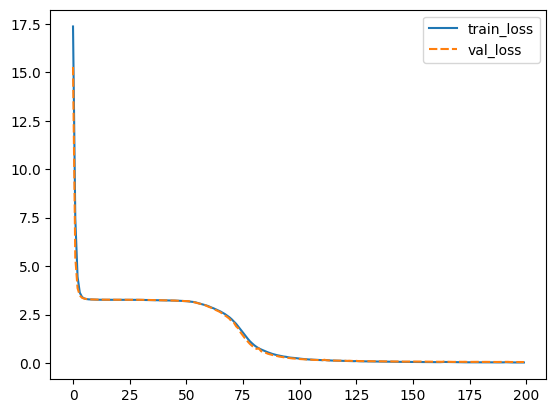

In [13]:
train_val_loss = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})
sns.lineplot(data=train_val_loss)

# 3. Подсчет метрик

In [14]:
cer = model.evaluations(test_loader, LabelEncoder)
print(f"CER: {cer}")

CER: 0.006517691072076559


# 4. Анализ ошибок модели

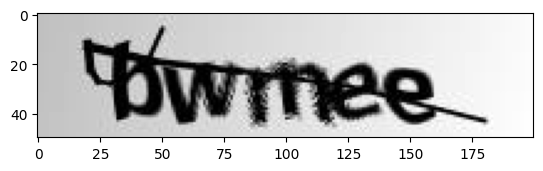

CER: 0.3333333432674408 True label: bwmee Predict label: bwnnee


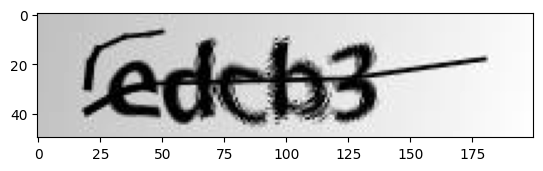

CER: 0.20000000298023224 True label: cdcb3 Predict label: edcb3


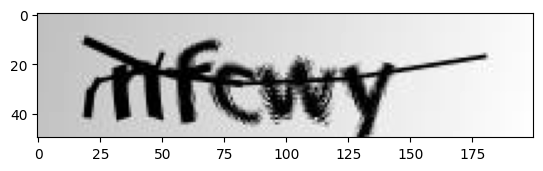

CER: 0.20000000298023224 True label: nfcwy Predict label: mfcwy


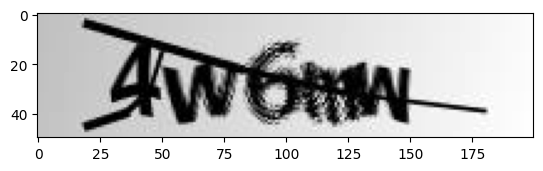

CER: 0.1666666716337204 True label: 4w6mw Predict label: 4w6mmw


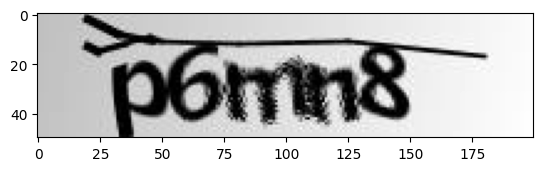

CER: 0.1666666716337204 True label: p6mn8 Predict label: p6mnn8


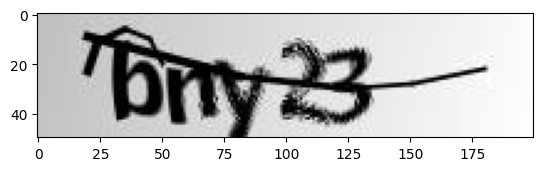

CER: 0.1666666716337204 True label: bny23 Predict label: bmny23


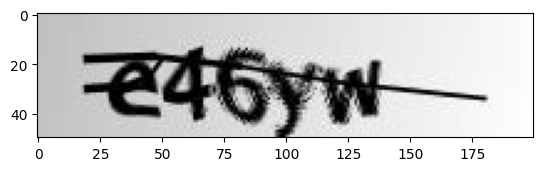

CER: 0.0 True label: e46yw Predict label: e46yw


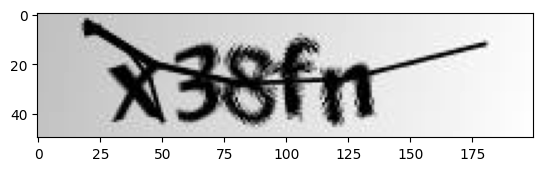

CER: 0.0 True label: x38fn Predict label: x38fn


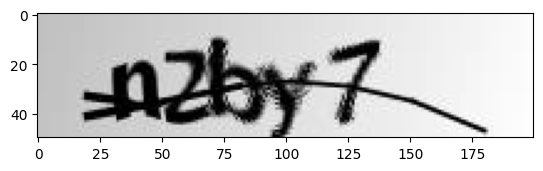

CER: 0.0 True label: n2by7 Predict label: n2by7


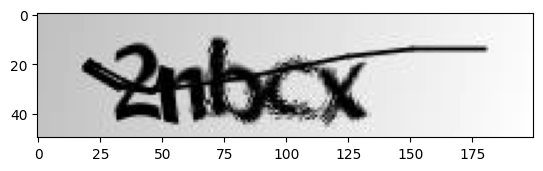

CER: 0.0 True label: 2nbcx Predict label: 2nbcx


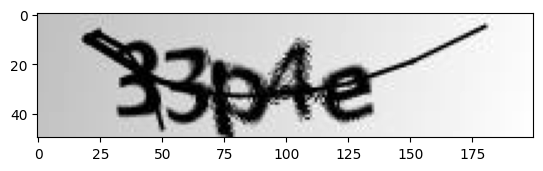

CER: 0.0 True label: 33p4e Predict label: 33p4e


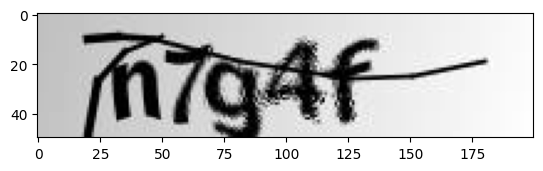

CER: 0.0 True label: n7g4f Predict label: n7g4f


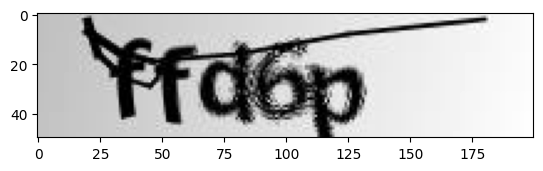

CER: 0.0 True label: ffd6p Predict label: ffd6p


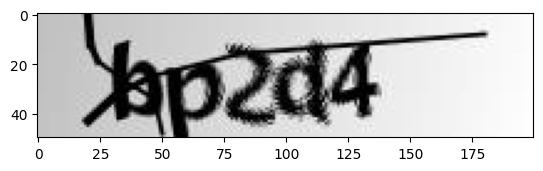

CER: 0.0 True label: bp2d4 Predict label: bp2d4


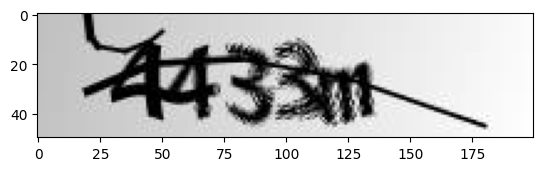

CER: 0.0 True label: 4433m Predict label: 4433m


In [15]:
import torchvision
list_cer = model.evaluations(test_loader, LabelEncoder, True)
sorted_list_cer = sorted(list_cer, key=lambda tup: tup["CER"], reverse=True)
show_first = 15
for elem in sorted_list_cer[:min(show_first, len(sorted_list_cer))]:
    show_landmarks(elem["img"])
    print(f"CER: {elem['CER']} True label: {elem['true_label']} Predict label: {elem['pred_label']}")

## Анализ

Как можно наблюдать из вывода сверху ошибки в символах возникают тогда, когда символы зашумлены. 

Для решения данной проблемы можно воспользоваться морфологическими преобразованиями: (https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html).
А именно расширением изображения и последующим сужением для устранения шума. (Попробовал, CER: 0.0084 обучение ниже не стал удалять)

Также можно добавить сверточные слои, увеличить размер текущих

# Проверка гипотезы

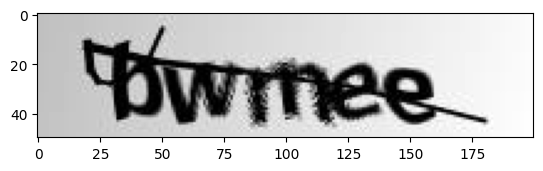

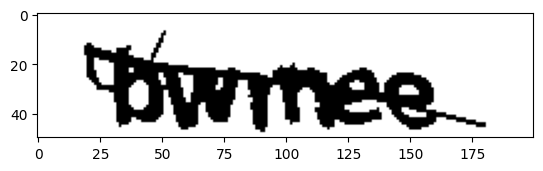

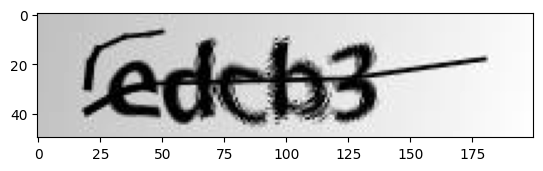

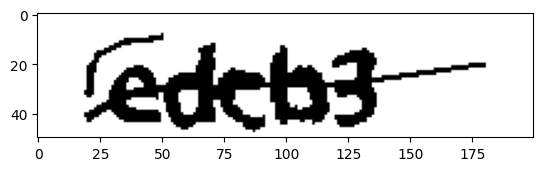

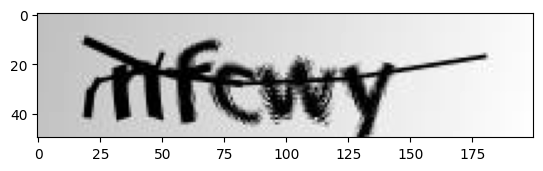

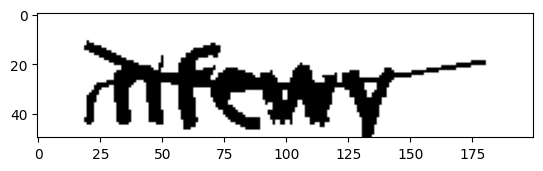

In [16]:
import cv2 as cv
show_ = 3
kernel = np.ones((2, 2), np.uint8)
for elem in sorted_list_cer[:min(show_, len(sorted_list_cer))]:
    show_landmarks(elem["img"])
    pil_image = transforms.ToPILImage()(elem["img"]) 
    img = np.array(pil_image)
    # img_dilation = cv.dilate(open_cv_image, kernel, iterations=1)
    # img = cv.fastNlMeansDenoising(img, 50,10,7,21)
    # img =  cv.morphologyEx(img,cv.MORPH_OPEN, kernel)
    # img = cv.erode(img, kernel, iterations=1)
    img =  cv.morphologyEx(img,cv.MORPH_CLOSE, (2, 1))
    # img = cv.dilate(img, kernel, iterations=1)
    img = cv.erode(img, (2,2), iterations=1)
    img = cv.dilate(img, kernel, iterations=1)
    ret,img = cv.threshold(img, 170, 255, cv.THRESH_BINARY)
    show_landmarks(img)

path_save_transform_images = "./../data/transforms/"
os.makedirs(path_save_transform_images, exist_ok=True)
for name_image in os.listdir(path_to_data):
    img = cv.imread(os.path.join(path_to_data, name_image))
    img =  cv.morphologyEx(img,cv.MORPH_CLOSE, (2, 1))
    img = cv.erode(img, (2,2), iterations=1)
    img = cv.dilate(img, kernel, iterations=1)
    ret,img = cv.threshold(img, 170, 255, cv.THRESH_BINARY)
    cv.imwrite(os.path.join(path_save_transform_images, name_image), img)

In [17]:
path_to_annotations = "./../data/list_transforms_images.csv"
path_to_data = "./../data/transforms"
load = False
epochs = 200

In [18]:
create_annotations(path_to_data, path_to_annotations)    
image_file_paths, labels_encoded, LabelEncoder = extract_data(path_to_annotations)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_loader, test_loader = create_loaders(image_file_paths,
                                           labels_encoded,
                                           transform,
                                           batch_size,
                                           test_size=0.2)

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Current device {device}')

model = OCR()
model.to(device)
if load:
    print("Loading model")
    model.load(load)

train_loss, val_loss = model.train(train_loader,
                                    test_loader,
                                    LabelEncoder,
                                    num_epochs=epochs)

Current device cuda
Epoch: 5 Train loss: 3.3074924094336375 Validation loss: 3.3000029921531677
('p6mn8', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
('e46yw', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
('pmg55', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
('cdcb3', ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_

<AxesSubplot: >

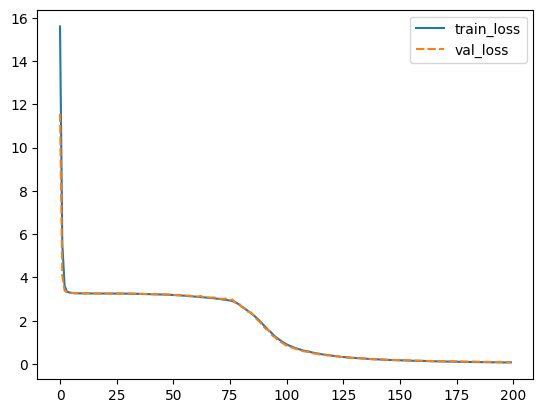

In [22]:
train_val_loss = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})
sns.lineplot(data=train_val_loss)

In [23]:
cer = model.evaluations(test_loader, LabelEncoder)
print(f"CER: {cer}")

CER: 0.008395522832870483
